In [21]:
## imports

import os
import matplotlib
from pathlib import Path
import math
import glob
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
import napari
import gunpowder as gp
import warnings
warnings.filterwarnings('ignore')

### Load data

In [3]:
base_path = Path("/mnt/shared/celltracking/data/cho/")
#base_path = Path("/mnt/shared/celltracking/data/celegans/")
img = np.stack([imread(xi) for xi in sorted((base_path / "01").glob("*.tif"))])  # images
seg = np.stack([imread(xi) for xi in sorted((base_path / "01_ST/SEG").glob("*.tif"))])  # images
tra = np.stack([imread(xi) for xi in sorted((base_path / "01_GT/TRA").glob("*.tif"))])  # images

### Have a look at data structure

### View imported data with napari

In [ ]:
viewer = napari.Viewer()
viewer.add_image(img, name="image");
viewer.add_image(tra,name='tra');
viewer.add_image(seg,name='seg');

### View flatened images

In [5]:
img_flat = img.sum(axis=1)
tra_flat = tra.sum(axis=1)
img_flat.shape
viewer.add_image(img_flat, name="image_flat");
viewer.add_image(tra_flat,name='tra_flat');

In [ ]:
# provide path to zarr directory
#zarrdir = '/mnt/shared/celltracking/data/cho/01.zarr'

In [ ]:
#f = zarr.open(zarrdir, 'w')
#f['raw'] = raw_data
#f['raw'].attrs['resolution'] = (1, 1, 1)
#f['ground_truth'] = gt_data
#f['ground_truth'].attrs['resolution'] = (1, 1, 1)


### Look at subvolumes extracted with gunpowder

batch returned: 
	raw: ROI: [0:1, 0:5, 65:165, 160:260] (1, 5, 100, 100), voxel size: (1, 1, 1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



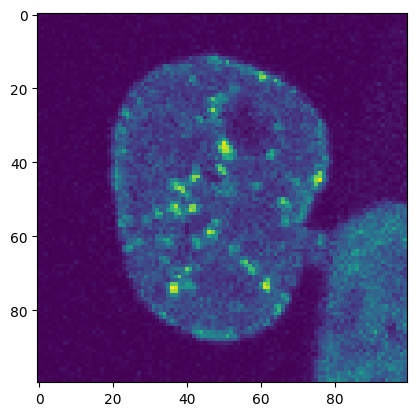

In [60]:
# provide path to zarr directory
zarrdir = '/mnt/shared/celltracking/data/cho/01.zarr'

coord_paired = ((0,0,65, 160),(1,0,67, 165))
coord_unpaired = ((0,0,65, 160),(1,0,60, 200))

# s
volSize = (1,5,100, 100)
coord = coord_paired[0]

# declare arrays to use in the pipeline
key ='raw'
raw = gp.ArrayKey(key)

# create "pipeline" consisting only of a data source
source = gp.ZarrSource(
    zarrdir,  # the zarr container
    {raw: key},  # which dataset to associate to the array key
    {raw: gp.ArraySpec(interpolatable=True, voxel_size=(1,1,1,1))}  # meta-information
)
pipeline = source#gp.Pipeline(source)
# formulate a request for "raw"

# specify request 
request = gp.BatchRequest()
request[raw] = gp.Roi(coord, volSize)

# build the pipeline
with gp.build(pipeline):
      batch = pipeline.request_batch(request)
    
# show the content of the batch
print(f"batch returned: {batch}")

# plot first slice of volume
plt.imshow(np.flipud(batch[raw].data[0,0,:,:]))

# load volume into napari
# viewer = napari.Viewer()
# viewer.add_image(batch[raw].data, name="volume 1");

In [76]:
#Augmentations=

# chose a random source (i.e., sample) from the above
#random_location = gp.RandomLocation()

# elastically deform the batch
Elastic_augment=gp.ElasticAugment(
    [4,40,40],
    [0,2,2],
    [0,math.pi/2.0],
    prob_slip=0.05,
    prob_shift=0.05,
    max_misalign=25)

# apply transpose and mirror augmentations
Simple_augment=gp.SimpleAugment(transpose_only=[2, 3]) 

# scale and shift the intensity of the raw array
Intensity_augment=gp.IntensityAugment(
    raw,
    scale_min=0.9,
    scale_max=1.1,
    shift_min=-0.1,
    shift_max=0.1,
    ) 

pipeline = (
    source + gp.Normalize(raw)+
            Intensity_augment+Elastic_augment + Simple_augment
           )


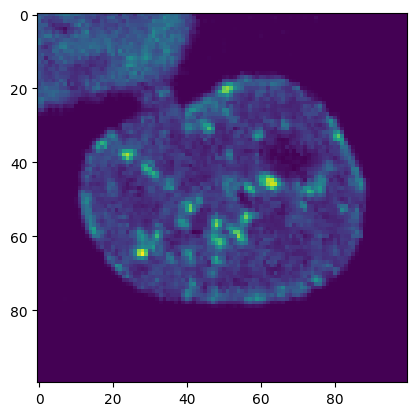

In [78]:
with gp.build(pipeline):
    batch = pipeline.request_batch(request)

plt.imshow(np.flipud(batch[raw].data[0,0,:,:]))

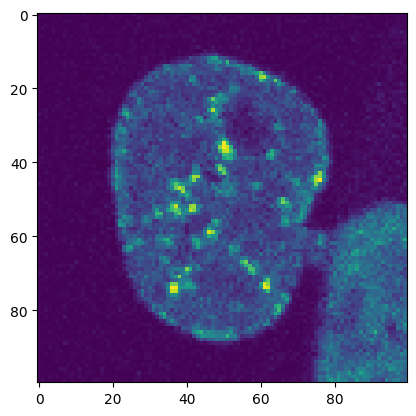

In [69]:
plt.imshow(np.flipud(batch[raw].data[0,0,:,:]))

In [31]:
with gp.build(pipeline):
    batch = pipeline.request_batch(request)

plt.imshow(np.flipud(batch[raw].data[0,0,:,:]))

PipelineRequestError: Exception in pipeline:
ZarrSource[/mnt/shared/celltracking/data/cho/01.zarr] -> RandomLocation -> ElasticAugment -> SimpleAugment -> IntensityAugment
while trying to process request

	raw: ROI: [0:1, 0:5, 65:165, 160:260] (1, 5, 100, 100), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
